This is an analysis of how the data is organized to be used as input for a machine learning model (linear regression) in the post [“How to Leverage the Pipeline to Conduct Machine Learning in the IDE”][2] by Jim Obreen.

Also some visual exploration (scatter plots) of the relation between the predicted variable __y__ (the log return of the stocks after 5 days)  and each one of the prediction variables (Volume, cf_yield, earning_yield, pb_ratio, pe_ratio and roa) and the R^2 factor of the regression are presented for the Mondays in January and may 2019 are presented. 

 [2]: https://www.quantopian.com/posts/how-to-leverage-the-pipeline-to-conduct-machine-learning-in-the-ide

In [1]:
"""
This is a demo algorithm to show folks how to conduct some rudimentary machine learning on Morningstar Fundamental data in the Quantopian IDE.
"""
 
##################################################
# Imports
##################################################
 
from __future__ import division
from collections import OrderedDict
import time
 
# Pipeline, Morningstar, and Quantopian Trading Functions
from quantopian.pipeline import Pipeline, CustomFactor
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.optimize import TargetWeights
 
# The basics
import pandas as pd
import numpy as np
 
# SKLearn :)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer, StandardScaler

import matplotlib.pyplot as plt
 
##################################################
# Globals
##################################################
 
num_holding_days = 5 # holding our stocks for five trading days.
days_for_fundamentals_analysis = 30
 

In [2]:
##################################################
# Pipeline-Related Code
##################################################
 
class Predictor(CustomFactor):
    """ Defines our machine learning model. """
 
    # The factors that we want to pass to the compute function. We use an ordered dict for clear labeling of our inputs.
    factor_dict = OrderedDict([
              ('Open Price' , USEquityPricing.open),
              ('Volume' , USEquityPricing.volume),
              ('cf_yield' , Fundamentals.cf_yield),
              ('earning_yield' , Fundamentals.earning_yield),
              ('pb_ratio' , Fundamentals.pb_ratio),
              ('pe_ratio' , Fundamentals.pe_ratio), 
              ('roa' , Fundamentals.roa)
              ])
 
    columns = factor_dict.keys()
    print "columns"
    print columns
    inputs = factor_dict.values()
 
    # Run it.
    def compute(self, today, assets, out, *inputs):
        """ Through trial and error, I determined that each item in the input array comes in with rows as days and securities as columns. Most recent data is at the "-1" index. Oldest is at 0.
 
        !!Note!! In the below code, I'm making the somewhat peculiar choice  of "stacking" the data... you don't have to do that... it's just a design choice... in most cases you'll probably implement this without stacking the data.
        """
 
        ## Import Data and define y.
        inputs = OrderedDict([(self.columns[i] , pd.DataFrame(inputs[i]).fillna(method='ffill',axis=1).fillna(method='bfill',axis=1)) for i in range(len(inputs))]) # bring in data with some null handling.
        
        
        #print "inputs"
        #print inputs
        
        num_secs = len(inputs['Open Price'].columns)
                
        y = (np.log(inputs['Open Price']) - np.log(inputs['Open Price'].shift(num_holding_days))).shift(-num_holding_days-1).dropna(axis=0,how='all').stack(dropna=False)
        
        #print "y"
        #print y
        
        ## Get rid of our y value as an input into our machine learning algorithm.
        del inputs['Open Price']
 
        ## Munge X and y
        x = pd.concat([df.stack(dropna=False) for df in inputs.values()], axis=1)
        x.columns = self.columns[1:]
        
    
        x = Imputer(strategy='median',axis=1).fit_transform(x) # fill nulls.
        
                
        y = np.ravel(Imputer(strategy='median',axis=1).fit_transform(y)) # fill nulls.
        
        scaler = StandardScaler()
        x = scaler.fit_transform(x) # demean and normalize
        
        #print "x"
        #print x
        
        #print "y"
        #print y
        
        plt.subplot(2, 3, 1)
        plt.scatter(x[:-num_secs*(num_holding_days+1),0],y) 
        plt.xlabel('Volume')
        plt.ylabel('y')

        plt.subplot(2, 3, 2)
        plt.scatter(x[:-num_secs*(num_holding_days+1),1],y)  
        plt.xlabel('cf_yield')
        plt.ylabel('y')

        plt.subplot(2, 3, 3)
        plt.scatter(x[:-num_secs*(num_holding_days+1),2],y) 
        plt.xlabel('earning_yield')
        plt.ylabel('y')

        plt.subplot(2, 3, 4)
        plt.scatter(x[:-num_secs*(num_holding_days+1),3],y)
        plt.xlabel('pb_ratio')
        plt.ylabel('y')

        plt.subplot(2, 3, 5)
        plt.scatter(x[:-num_secs*(num_holding_days+1),4],y) 
        plt.xlabel('pe_ratio')
        plt.ylabel('y')

        plt.subplot(2, 3, 6)
        plt.scatter(x[:-num_secs*(num_holding_days+1),5],y)
        plt.xlabel('roa')
        plt.ylabel('y')              
        
        ## Run Model
        model = LinearRegression() # you'll probably use something more involved here... this is just quick, for demo purposes.
        model_x = x[:-num_secs*(num_holding_days+1),:]
        model.fit(model_x, y)
        
        print 'R = {:.2f}%', model.score(model_x,y)
        
        out[:] = model.predict(x[-num_secs:,:])
 
 
def make_pipeline():
 
    universe = QTradableStocksUS()
 
    pipe = Pipeline(columns={'Model': Predictor(window_length=days_for_fundamentals_analysis, mask=universe)},screen = universe)
 
    return pipe

columns
['Open Price', 'Volume', 'cf_yield', 'earning_yield', 'pb_ratio', 'pe_ratio', 'roa']


In the Predictor construction after the instruction

*inputs = OrderedDict([(self.columns[i] , pd.DataFrame(inputs[i]).fillna(method='ffill',axis=1).fillna(method='bfill',axis=1)) for i in range(len(inputs))]) # bring in data with some null handling.*

The data in the __input__ array have the following structureeach item in the input ordered dictionary is an two dimentional panel with rows as days and securities as columns, see the next figure:

![AnalysisObreen1.png](https://raw.githubusercontent.com/gjhernandezp/AT/master/AnalysisObreen1.png) 

The target variable  hat we are trying predict from the information in __input__  vareibales is the return of the stocks after the number days that we are holding the stocks (we are holding our stocks for five trading days)

Our target variable is called __y__  and is calulated using the Open Price and Open Price 5 days before (obatined shifting Open Price num_holding_days rows) after that we shif the the values last -num_holding_days-1 to get the corresponding 5 day furture retunrs, elimnate the NaN values and stack the values, see the next figure:

![AnalysisObreen2.png](https://raw.githubusercontent.com/gjhernandezp/AT/master/AnalysisObreen2.png)

To build the corresponding input __x__  for the machine leraning model we stack each entry in the ordered dictionary __inputs__ and the concat ecah as a column of __x__ as shown in the next figure.

![AnalysisObreen3.png](https://raw.githubusercontent.com/gjhernandezp/AT/master/AnalysisObreen3.png)

x and y are imputed,  demean and normalized before training the linear regressor.


R = {:.2f}% 0.00162291232612


Time to run pipeline 9.16 secs


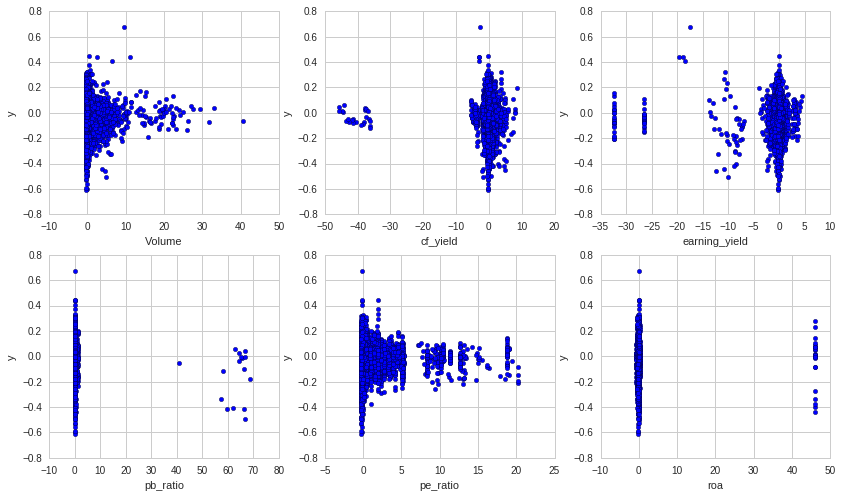

In [3]:
from quantopian.research import run_pipeline
from time import time
start = pd.Timestamp("2019-01-07")
end = pd.Timestamp("2019-01-07")
start_timer = time()
results = run_pipeline(make_pipeline(), start_date=start, end_date=end)
results.index.names = ['date', 'security']
end_timer = time()
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

R = {:.2f}% 0.0017744085011


Time to run pipeline 3.82 secs


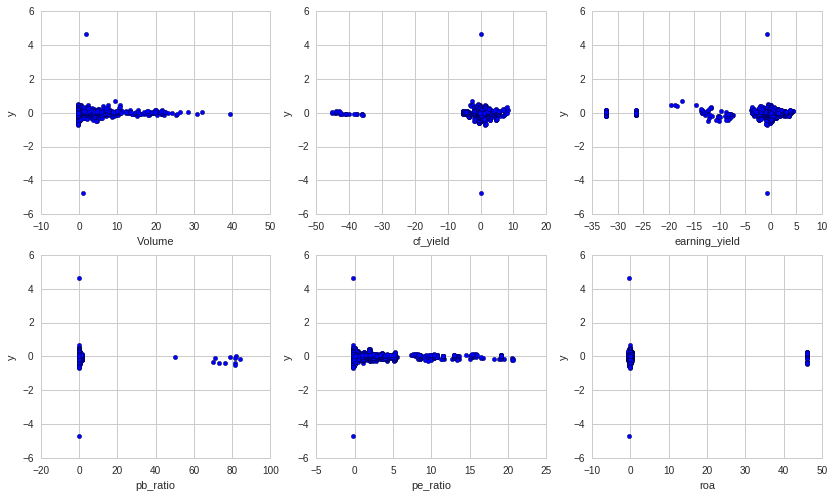

In [4]:
start = pd.Timestamp("2019-01-14")
end = pd.Timestamp("2019-01-14")
start_timer = time()
results = run_pipeline(make_pipeline(), start_date=start, end_date=end)
results.index.names = ['date', 'security']
end_timer = time()
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

R = {:.2f}% 0.0022868078609


Time to run pipeline 3.27 secs


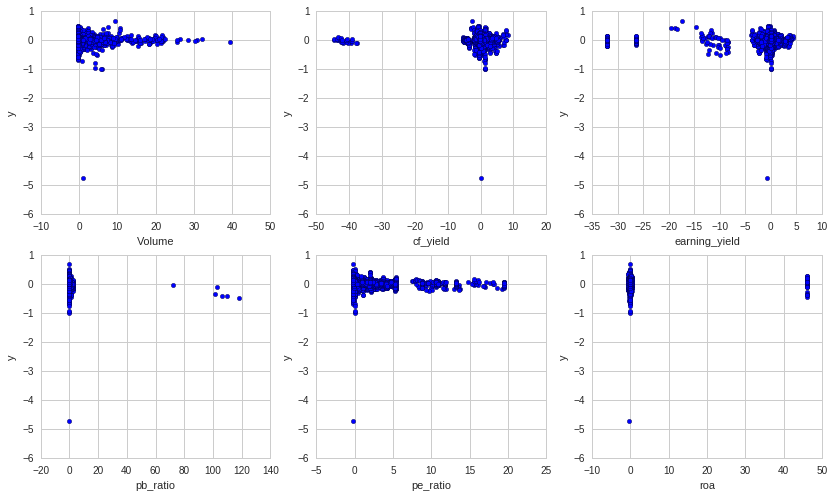

In [5]:
start = pd.Timestamp("2019-01-21")
end = pd.Timestamp("2019-01-21")
start_timer = time()
results = run_pipeline(make_pipeline(), start_date=start, end_date=end)
results.index.names = ['date', 'security']
end_timer = time()
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

R = {:.2f}% 0.000225356496971


Time to run pipeline 3.32 secs


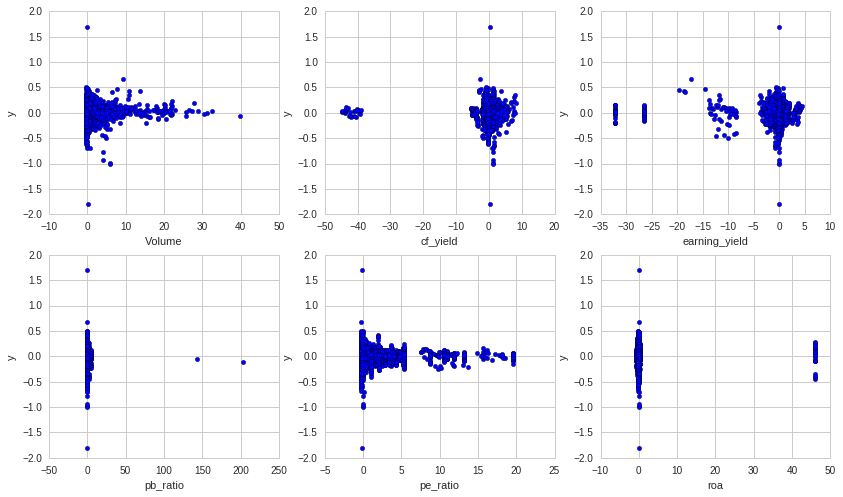

In [6]:
start = pd.Timestamp("2019-01-28")
end = pd.Timestamp("2019-01-28")
start_timer = time()
results = run_pipeline(make_pipeline(), start_date=start, end_date=end)
results.index.names = ['date', 'security']
end_timer = time()
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

R = {:.2f}% 0.00594812687638


Time to run pipeline 3.74 secs


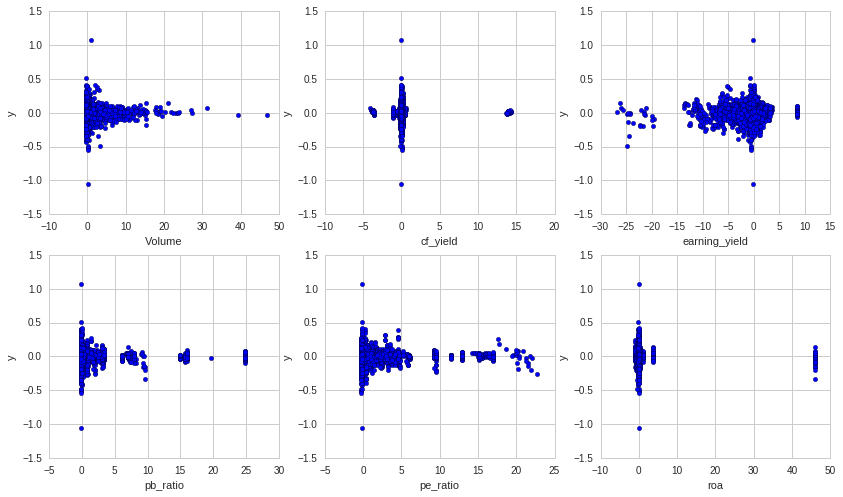

In [7]:
start = pd.Timestamp("2019-05-06")
end = pd.Timestamp("2019-05-06")
start_timer = time()
results = run_pipeline(make_pipeline(), start_date=start, end_date=end)
results.index.names = ['date', 'security']
end_timer = time()
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

R = {:.2f}% 0.00340487006397


Time to run pipeline 3.67 secs


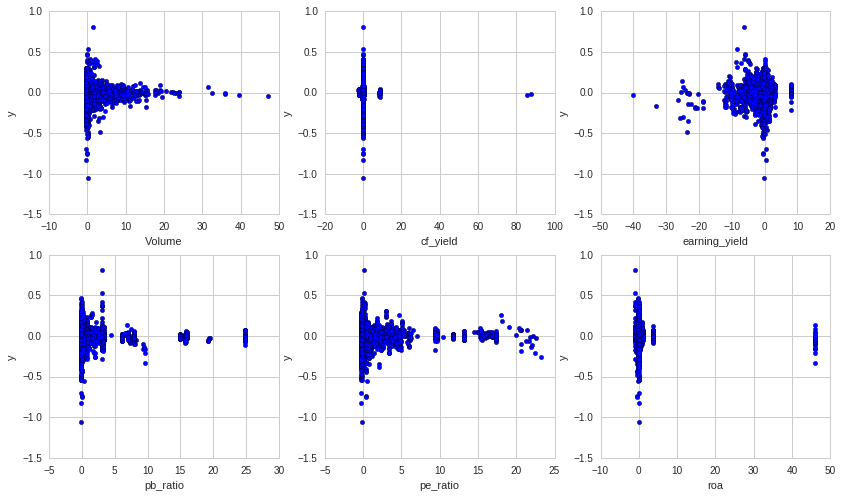

In [8]:
start = pd.Timestamp("2019-05-13")
end = pd.Timestamp("2019-05-13")
start_timer = time()
results = run_pipeline(make_pipeline(), start_date=start, end_date=end)
results.index.names = ['date', 'security']
end_timer = time()
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

R = {:.2f}% 0.00053608246762


Time to run pipeline 3.21 secs


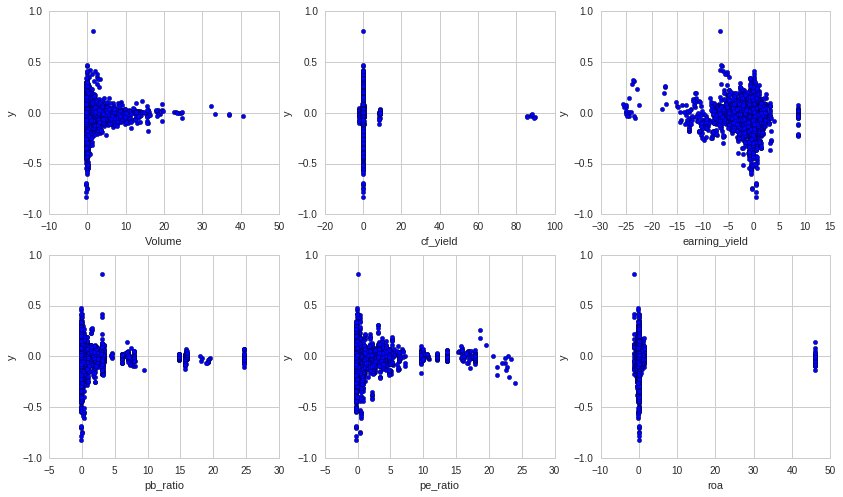

In [9]:
start = pd.Timestamp("2019-05-20")
end = pd.Timestamp("2019-05-20")
start_timer = time()
results = run_pipeline(make_pipeline(), start_date=start, end_date=end)
results.index.names = ['date', 'security']
end_timer = time()
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

R = {:.2f}% 0.00116630789774


Time to run pipeline 3.42 secs


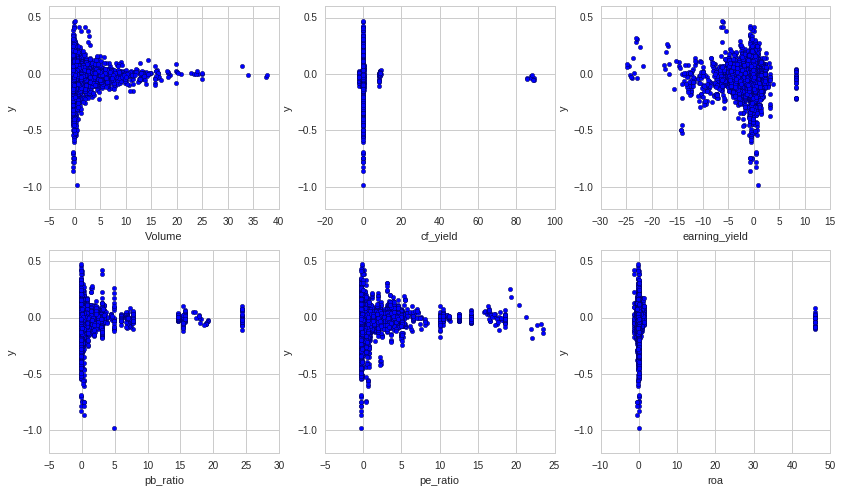

In [10]:
start = pd.Timestamp("2019-05-27")
end = pd.Timestamp("2019-05-27")
start_timer = time()
results = run_pipeline(make_pipeline(), start_date=start, end_date=end)
results.index.names = ['date', 'security']
end_timer = time()
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)